<a href="https://colab.research.google.com/github/Navya003/NLP/blob/main/w2v_bio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip install commands
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 8.3 MB/s 
     |████████████████████████████████| 182 kB 53.3 MB/s 
     |████████████████████████████████| 166 kB 48.9 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 166 kB 50.4 MB/s 
     |████████████████████████████████| 162 kB 48.6 MB/s 
     |████████████████████████████████| 162 kB 46.8 MB/s 
     |████████████████████████████████| 158 kB 61.6 MB/s 
     |████████████████████████████████| 157 kB 48.5 MB/s 
     |████████████████████████████████| 157 kB 49.1 MB/s 
     |████████████████████████████████| 157 kB 48.3 MB/s 
     |████████████████████████████████| 157 kB 47.7 MB/s 
     |████████████████████████████████| 157 kB 44.5 MB/s 
     |████████████████████████████████| 157 kB 55.7 MB/s 
     |████████████████████████████████| 157 kB 58.1 MB/s 
     |████████████████████████████

In [ ]:
# importing all the required modules
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials, space_eval
import wandb

In [ ]:
#functions
def split_dataset(X, Y, train_ratio, test_ratio, validation_ratio):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=1 - train_ratio)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))
    return x_train, y_train, x_test, y_test, x_val, y_val

def train_model(model, param, x_train, y_train):
     clf=model(param)
     # fit the training data into the model
     clf.fit(x_train, y_train)
     y_pred=clf.predict(x_test)
     y_probas=clf.predict_proba(x_test)
     return clf, y_pred, y_probas

def model_metrics(model, x_test, y_test, y_pred):
  # accuracy prediction
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  # classification report
  print("Classification report:\n")
  print(classification_report(y_test, y_pred))
  # confusion matrix
  conf=confusion_matrix(y_test, y_pred)
  print("Confusion matrix:\n", conf)

def grid_search(model, param, scoring):
    clf_grid=GridSearchCV(estimator=model, param_grid=param, scoring = scoring , refit = 'recall' , cv = 3, verbose=2, n_jobs = 4)
    # fit the training data
    clf_grid.fit(x_train,y_train)
    # Best hyperparameter values
    print('Best parameter values:')
    print(clf_grid.best_params_)
    # predicted values from the grid search model
    clf_g=clf_grid.best_estimator_
    y_pred=clf_g.predict(x_test)
    y_probas = clf_g.predict_proba(x_test)
    return clf_g, y_pred, y_probas

def random_search(model, param, scoring):
    clf_ran=RandomizedSearchCV(estimator=model, param_distributions = param, scoring = scoring, refit = 'recall', cv = 3, verbose=2, n_jobs = 4)
    # fit the training data
    clf_ran.fit(x_train,y_train)
    # Best hyperparameter values
    print('Best parameter values:')
    print(clf_ran.best_params_)
    # predicted values from the random search model
    clf_r=clf_ran.best_estimator_
    y_pred=clf_r.predict(x_test)
    y_probas = clf_r.predict_proba(x_test)
    return clf_r, y_pred, y_probas

# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)


def BayesianOptimisation(model,space,scoring):
    # Set up the k-fold cross-validation
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    # Objective function
    def objective(params):
      #clf = model(seed=0, **params)
      #scores = cross_val_score(model, x_train, y_train, cv=kfold, scoring= scoring , n_jobs=4)
      scores = cross_validate(model, x_train, y_train, cv=kfold, scoring= scoring , n_jobs=4)
      best_score = max(scores)   # Extract the best scorebest_score = max(scores)
      # Loss must be minimized
      loss =  best_score
      # Dictionary with information for evaluation
      return {'loss': loss, 'params': params, 'status': STATUS_OK}
    # Trials to track progress
    bayes_trials = Trials()
    # Optimize
    best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 48, trials = bayes_trials)
    # Print the index of the best parameters
    print(best)
    # Print the values of the best parameters
    print(space_eval(space, best))
    # Train model using the best parameters
    clf_o = model(space_eval(space, best)).fit(x_train,y_train)
    y_pred = clf_o.predict(x_test)
    y_probas = clf_o.predict_proba(x_test)
    return clf_o, y_pred, y_probas

def feature_imp(model,feature_names, n_top_features):
  feats=np.array(feature_names)
  importances = model.feature_importances_
  print('total features:', len(importances))
  indices = np.argsort(importances)[::-1]
  #for f in range(50):
    #print("%d. feature %d - %s : %f" % (f+1, indices[f], feats[f], importances[indices[f]]))
  plt.figure(figsize=(8,10))
  plt.barh(feats[indices][:n_top_features ], importances[indices][:n_top_features ])
  plt.xlabel("RF feature Importance ")

def token_freq_plot(token, top_features):
  #wandb.init(project='test-RF', name='Token Frequency distribution plot')
  freq=token.value_counts().nlargest(top_features)
  freq.plot(kind='bar', title='Token frequency distribution plot')
  #wandb.log({'plt':freq})
  #wandb.finish()

def exporting_metrics(entity, project):
  api = wandb.Api()

  runs = api.runs(entity + "/" + project)

  summary_list, config_list, name_list = [], [], []
  for run in runs:
      # .summary contains the output keys/values for metrics like accuracy.
      summary_list.append(run.summary._json_dict)
      # .config contains the hyperparameters.
      #  We remove special values that start with _.
      config_list.append(
          {k: v for k,v in run.config.items()
           if not k.startswith('_')})
      # .name is the human-readable name of the run.
      name_list.append(run.name)

  runs_df = pd.DataFrame({
      "summary": summary_list,
      "config": config_list,
      "name": name_list
      })

  runs_df.to_csv('metrics.csv')


In [ ]:
# importing the embeddings
pos = pd.read_csv("Positive.w2v", skiprows=1, sep=" ", index_col=0, header=None)
neg = pd.read_csv("Negative.w2v", skiprows=1, sep=" ", index_col=0, header=None)
# data preprocessing
# adding labels for natural and synthetic embeddings
pos['label']=1
neg['label']=0
# dataset
df=pd.concat([pos,neg])
df.index.name='kmer'
#df.head()
df[:] = np.nan_to_num(df)
#Token freq plot
#token_freq_plot(df.index, 30)

# split data into X and Y
# sequence embeddings
X=np.array(df.drop(['label'], axis=1))
# label of sequence embeddings
Y=np.array(df['label'])
# X and Y should have same length
print(X.shape)
print(Y.shape)

# split the dataset into train, test and validation set using sklearn
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15
# train is now 70% of the entire data set
# test is now 15% of the initial data set
# validation is now 15% of the initial data set
x_train, y_train, x_test, y_test, x_val, y_val=split_dataset(X, Y, train_ratio, test_ratio, validation_ratio)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)



(174718, 100)
(174718,)
(122302, 100)
(122302,)
(26208, 100)
(26208,)
(26208, 100)
(26208,)


In [ ]:
# the logging should be done as part of an existing job
# if not, init an existing job
wandb.init(project='test RF', name="w2v")
freq = df.index.value_counts().nlargest(30)
freq = pd.DataFrame(freq).reset_index()
freq.columns = ["kmer", "frequency"]
freq = wandb.Table(data=freq, columns=["kmer", "frequency"])
wandb.log({"Token frequency distribution": wandb.plot.bar(freq, "kmer", "frequency", title="Token frequency distribution")})
wandb.finish()


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
len(df.index)

127802

RF BASE MODEL
Accuracy: 99.87%
Classification report:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13146
         1.0       1.00      1.00      1.00     13062

    accuracy                           1.00     26208
   macro avg       1.00      1.00      1.00     26208
weighted avg       1.00      1.00      1.00     26208

Confusion matrix:
 [[13135    11]
 [   23 13039]]
total features: 100


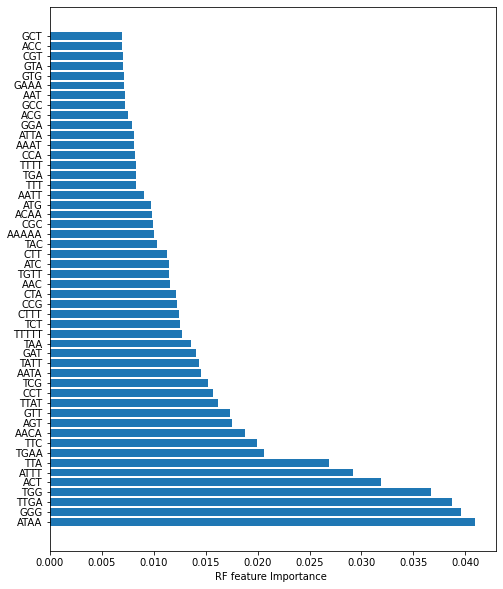

In [ ]:
print('RF BASE MODEL')
# training the model
model=RandomForestClassifier
param=100
rf_base, y_pred, y_probas=train_model(model, param, x_train, y_train)
# model metrics
model_metrics(rf_base, x_test, y_test, y_pred)
# SHAP Plot
#shap_plot(rf_base, x_test, df.index)
# wandb plot
#Feature imp plot
feature_imp(rf_base, df.index, 50)

In [ ]:
# wandb plot
# Visualize all classifier plots at once
wandb.init(project="test RF", name="RF-base model")
wandb.sklearn.plot_classifier(rf_base, x_train, x_test, y_train, y_test, y_pred, y_probas, labels=['Negative', 'Positive'], model_name='BASE MODEL', feature_names=df.index)
wandb.sklearn.plot_roc(y_val, y_probas, labels=None)

In [ ]:
# parameters cuurently used
print('Parameters currently in use:')
pprint(rf_base.get_params())

Parameters currently in use:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [ ]:
# Setting range of parameters
# Number of trees in random forest
#n_estimators = [1000, 2000, 3000]
n_estimators = [100]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [1, 2, 3]
# Minimum number of samples required to split a node
min_samples_split = [2,3]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

scoring = ['recall']

param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print('Range of parameters used for hyperparameter tuning:')
pprint(param)

Range of parameters used for hyperparameter tuning:
{'bootstrap': [True, False],
 'max_depth': [1, 2, 3],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 3],
 'n_estimators': [100]}



GRID SEARCH MODEL
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameter values:
{'bootstrap': False, 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 100}
Accuracy: 87.56%
Classification report:

              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87     12923
         1.0       0.88      0.87      0.88     13285

    accuracy                           0.88     26208
   macro avg       0.88      0.88      0.88     26208
weighted avg       0.88      0.88      0.88     26208

Confusion matrix:
 [[11351  1572]
 [ 1688 11597]]


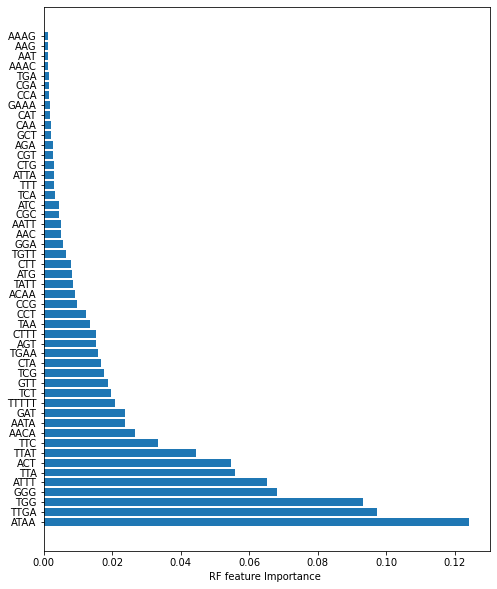

In [ ]:
# Hyperparameter tuning using GridsearchCV
print("\nGRID SEARCH MODEL")
# Grid Search model
rf_grid, y_pred1, y_probas1=grid_search(rf_base, param, scoring)
# model metrics
model_metrics(rf_grid, x_test, y_test, y_pred1)
# SHAP Plot
#shap_plot(rf_grid, x_test)
#Feature imp plot
feature_imp(rf_grid, df.index, 50)

In [ ]:
# wandb plot
# Visualize all classifier plots at once
wandb.init(project="test RF", name="RF-Grid Search model")
wandb.sklearn.plot_classifier(rf_grid, x_train, x_test, y_train, y_test, y_pred1, y_probas1, labels=['Negative', 'Positive'], model_name='Grid Search Model', feature_names=df.index)

wandb: 
wandb: Plotting Grid Search Model.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.



RANDOM SEARCH MODEL
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameter values:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 3, 'bootstrap': True}
Accuracy: 87.63%
Classification report:

              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88     12923
         1.0       0.88      0.87      0.88     13285

    accuracy                           0.88     26208
   macro avg       0.88      0.88      0.88     26208
weighted avg       0.88      0.88      0.88     26208

Confusion matrix:
 [[11358  1565]
 [ 1677 11608]]


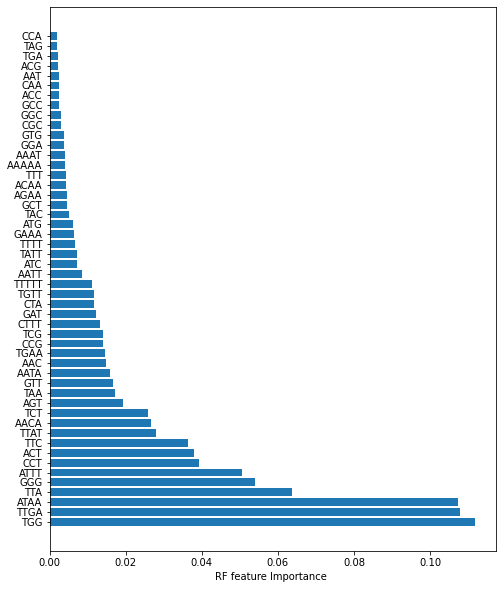

In [ ]:
print("\nRANDOM SEARCH MODEL")
# Random search model
rf_ran, y_pred2, y_probas2=random_search(rf_base, param, scoring)
# model metrics
model_metrics(rf_ran, x_test, y_test, y_pred2)
# SHAP Plot
#shap_plot(rf_ran, x_test)
#Feature imp plot
feature_imp(rf_ran, df.index, 50)

In [ ]:
# wandb plot
# Visualize all classifier plots at once
wandb.init(project="test RF", name="RF Random Search model")
wandb.sklearn.plot_classifier(rf_ran, x_train, x_test, y_train, y_test, y_pred2, y_probas2, labels=['Negative', 'Positive'], model_name='Random Search Model', feature_names=df.index)

wandb: 
wandb: Plotting Random Search Model.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [ ]:
# Bayesian optimization
print("\nBAYESIAN OPTIMIZATION")
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 1, 2, 3),
        'max_features': hp.choice('max_features', ['auto', 'sqrt']),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 1,2),
        'min_samples_split' : hp.uniform ('min_samples_split', 2, 3),
        'n_estimators' : hp.choice('n_estimators', [100, 200])
    }
rf_bayes, y_pred3, y_probas3=BayesianOptimisation(rf_base,space,scoring)
# model metrics
model_metrics(rf_bayes, x_test, y_test, y_pred3)
# SHAP Plot
#shap_plot(rf_bayes, x_test)
# wandb plot
# Visualize all classifier plots at once
#wandb.init(project="test RF", name="RF Bayesian op. model")
#wandb.sklearn.plot_classifier(rf_bayes, x_train, x_test, y_train, y_test, y_pred3, y_probas3, labels=None, model_name='Bayesian Optimization Model', feature_names=None)
#Feature imp plot
feature_imp(rf_bayes, df.index, 50)

In [ ]:
#wandb sweeps
def RFsweep():
    wandb.init(settings=wandb.Settings(console='off', start_method='fork'))
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(x_train, y_train)
    preds = clf.predict(x_test)
    pred_prob = clf.predict_proba(x_test)
    #print(classification_report(y_test, preds))
    # Log any metric with Weights and Biases
    wandb.log({'accuracy_score': accuracy_score(y_test,preds)})

In [ ]:
sweep_config = {
        'name'  : "random",
        'method': 'random', #grid, random
        'metric': {
          'name': 'accuracy_score',
          'goal': 'maximize' },
        'parameters': {
          "n_estimators" : {
          "values" : [100, 200]},
          "max_depth" :{
          "values": [10, 20, 30, 40, 50]},
          "min_samples_leaf":{
          "values":[1, 2, 3, 4, 5]},
          "min_samples_split":{
          "values":[1, 2, 3, 4, 5]}, }}

sweep_id = wandb.sweep(sweep_config, project='test sweep')
count=2
wandb.agent(sweep_id,function=RFsweep, count=count)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: d0k9lq1s
Sweep URL: https://wandb.ai/tyagilab/test%20sweep/sweeps/d0k9lq1s


wandb: Agent Starting Run: ljki64td with config:
wandb: 	max_depth: 40
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 200
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: navya-tyagi (tyagilab). Use `wandb login --relogin` to force relogin


accuracy_score,▁
accuracy_score,0.99809


wandb: Agent Starting Run: js6tonkw with config:
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 200
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy_score,▁
accuracy_score,0.99851


In [ ]:
sweep_config1 = {
        'name'  : "grid",
        'method': 'grid', #grid, random
        'metric': {
          'name': 'accuracy_score',
          'goal': 'maximize' },
        'parameters': {
          "n_estimators" : {
          "values" : [100, 200]},
          "max_depth" :{
          "values": [10, 20, 30, 40, 50]},
          "min_samples_leaf":{
          "values":[1, 2, 3, 4, 5]},
          "min_samples_split":{
          "values":[1, 2, 3, 4, 5]}, }}

sweep_id1 = wandb.sweep(sweep_config1, project='test sweep')
count=2
wandb.agent(sweep_id1,function=RFsweep, count=count)

Create sweep with ID: anknz6q4
Sweep URL: https://wandb.ai/tyagilab/test%20sweep/sweeps/anknz6q4


wandb: Agent Starting Run: b0qr56ks with config:
wandb: 	max_depth: 10
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 1
wandb: 	n_estimators: 100
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy_score,▁
accuracy_score,0.99832


wandb: Agent Starting Run: v34miazz with config:
wandb: 	max_depth: 10
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 1
wandb: 	n_estimators: 200
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy_score,▁
accuracy_score,0.99798


In [ ]:
# Exporting metrics from a project in to a CSV file
# set to your entity and project
exporting_metrics('tyagilab', 'test RF')